# Deep Learning based Models for Solar Energy Prediction

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages for building DRNN layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Reshape, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential

#Plotting graph
import matplotlib.pyplot as plt

#Plotting Keras Model
from tensorflow.keras.utils import plot_model

#Normalization of data
from sklearn.preprocessing import StandardScaler

#Utility Module for computing and displaying metrics
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

#Extracting dataset into train, validation and test sets
train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

scaler = StandardScaler()

#Extracting solar and wind X, y columns per set
X_solar_train = train[['SWTDN', 'SWGDN', 'T']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T']]
y_solar_test = test['DE_solar_generation_actual']

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

## Fitting the best ML for Solar

In [3]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

solarRegressor = HistGradientBoostingRegressor().fit(X_solar_train, y_solar_train)

## Modelling and Fitting the model for Wind

In [4]:
windRegressor = Sequential()
windRegressor.add(Input(shape=(4,)))
windRegressor.add(Reshape((-1,1)))
windRegressor.add(SimpleRNN(100, activation = 'tanh', input_shape = X_wind_train.shape, return_sequences=False))
windRegressor.add(Dense(100))
windRegressor.add(BatchNormalization())
windRegressor.add(Dense(1))
windRegressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4, 1)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


In [5]:
windRegressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
windRegressor.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=20, verbose = 0)

## Plotting Actual vs Predicted for Wind on same graph

In [6]:
total_train_pred = scaler.inverse_transform(
    windRegressor.predict(X_wind_train)) + solarRegressor.predict(X_solar_train).reshape((-1,1))
total_val_pred = scaler.inverse_transform(
    windRegressor.predict(X_wind_valid)) + solarRegressor.predict(X_solar_valid).reshape((-1,1))
total_test_pred = scaler.inverse_transform(
    windRegressor.predict(X_wind_test)) + solarRegressor.predict(X_solar_test).reshape((-1,1))

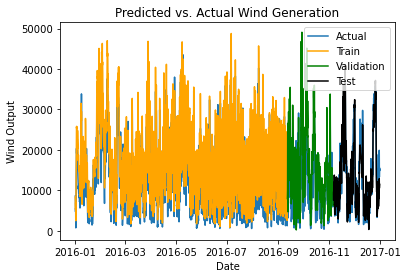

In [7]:
df = thesis_dataset[['total_renewable_generation']]

train_df = train[['total_renewable_generation']]
train_df.loc[:, 'total_renewable_generation'] = total_train_pred

valid_df = valid[['total_renewable_generation']]
valid_df.loc[:, 'total_renewable_generation'] = total_val_pred

test_df = test[['total_renewable_generation']]
test_df.loc[:, 'total_renewable_generation'] = total_test_pred

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

### Regression Metrics for the Combined Model

In [8]:
metrics('drnn', test[['total_renewable_generation']], total_test_pred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,1984.860906,2508.36894,50.083619,3.913694,0.916849
